In [1]:
using NCDatasets
using PyPlot
using Dates
using Statistics
using Glob
using Test
const plt = PyPlot
include("./config.jl");
include("./ME4OH.jl")
doplot = false
using Pkg
Pkg.add(url="https://github.com/gher-uliege/DIVAnd.jl", rev="master")
using DIVAnd

[ Info: File already downloaded
     Cloning git-repo `https://github.com/gher-uliege/DIVAnd.jl`
    Updating git-repo `https://github.com/gher-uliege/DIVAnd.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Adapt ─────────────── v4.0.1
   Installed RecursiveArrayTools ─ v3.5.4
   Installed SciMLBase ─────────── v2.20.0
┌ Error: Error watching manifest
│   exception =
│    cannot set type for global Bzip2_jll.best_wrapper. It already has a value or is already set to a different type.
│    Stacktrace:
│     [1] top-level scope
│       @ ~/.julia/packages/JLLWrappers/pG9bm/src/toplevel_generators.jl:119
│    Revise evaluation error at /home/ctroupin/.julia/packages/JLLWrappers/pG9bm/src/toplevel_generators.jl:119
│    
│    Stacktrace:
│     [1] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{…}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::@Kwa

Precompiling project...
  ✓ Adapt
  ✓ Adapt → AdaptStaticArraysExt
  ✓ GPUArraysCore
  ✓ ArrayInterface → ArrayInterfaceGPUArraysCoreExt
  ✓ Interpolations
  ✓ RecursiveArrayTools
  ✓ SciMLBase
  ✓ SciMLBase → SciMLBaseChainRulesCoreExt
  ✓ LinearSolve
  ✓ LinearSolve → LinearSolveIterativeSolversExt
  ✓ LinearSolve → LinearSolveRecursiveArrayToolsExt
  ✓ AlgebraicMultigrid
    DIVAnd Being precompiled by another process (pid: 57127, pidfile: /home/ctroupin/.julia/compiled/v1.10/DIVAnd/AaVxY_sTiHS.ji.pidfile)
  ✓ DIVAnd
  13 dependencies successfully precompiled in 86 seconds. 131 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
[ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, 

┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callbacks(extid::Base.ExtensionId)
│        @ Base ./loading.jl:1289
│      [8] run_extension_callbacks(pkgid::Base.PkgId)
│        @ Base ./loading.jl:1324
│      [9] run_package_callbacks(modkey::Base.PkgId)
│   

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callbacks(extid::Base.ExtensionId)
│        @ Base ./loading.jl:1289
│      [8] run

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callbacks(extid::Base.ExtensionId)
│        @ Base ./loading.jl:1289
│      [8] run

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callbacks(extid::Base.ExtensionId)
│        @ Base ./loading.jl:1289
│      [8] run

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callbacks(extid::Base.ExtensionId)
│        @ Base ./loading.jl:1289
│      [8] run

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension OffsetArraysAdaptExt of OffsetArrays, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callbacks(extid::Base.ExtensionId)
│        @ Base ./loading.jl:1289
│      [8] run

In [30]:
pathof(DIVAnd)

"/home/ctroupin/.julia/packages/DIVAnd/BQFGA/src/DIVAnd.jl"

## Create list of netCDF files
The files with the "nonan" extension were moved to another directory.

In [3]:
datafilelist = ME4OH.get_filelist(datadir, timeperiod1)

2-element Vector{String}:
 "/home/ctroupin/data/ME4OH/data/" ⋯ 55 bytes ⋯ "f.profiles.g10.197901.update.nc"
 "/home/ctroupin/data/ME4OH/data/" ⋯ 55 bytes ⋯ "f.profiles.g10.197902.update.nc"

## Experiment B
We perform purely 2D interpolations by looping on the monthly periods and the depth levels.     
The land-sea mask is created on the 3 specified depth levels.

In [4]:
depth_dohc = [depthlayer1[end], depthlayer2[end], depthlayer3[end]]

3-element Vector{Float64}:
  286.6
  685.9
 1985.3

In [5]:
xi, yi, mask_dohc = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depth_dohc);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);

### Prepare the time grid 
According to the time period specified in `config.jl`.

In [6]:
timegrid1 = ME4OH.get_timegrid(timeperiod1);

## Perform analysis
### Create the netCDF files that will store the results
The output directory is specified in `config.jl`.

In [7]:
outputfilelist = []
for depthlayer in [depthlayer1, depthlayer2, depthlayer3]
    fname = make_fname(timeperiod1, depthlayer, "A")
    outputfile = joinpath(outputdir, fname)
    isfile(outputfile) ? rm(outputfile) : @debug("OK")
    create_netcdf_results(outputfile, longrid, latgrid, timegrid1)
    
    # Add the residual variables in the netCDF
    add_residuals(outputfile, datafilelist)
    
    # Add file to the list
    push!(outputfilelist, outputfile)
end

LoadError: UndefVarError: `make_fname` not defined

### Loop on the files and the depths

In [8]:
for (ntime, datafile) in enumerate(datafilelist)
    
    # Read observations
    lon, lat, dates, depth, T, S, dohc = read_profile(datafile)
    
    # Modify coordinates
    lon[lon .< 20.] .+= 360
    
    # Loop on the 3 depth levels
    for ii = 1:1
        
        # Select good values (no NaNs)
        obsval = dohc[ii,:]
        goodval = findall(.!isnan.(obsval));
        ngood = length(goodval)
        
        # Perform interpolation
        fi, s = DIVAndrun(mask_dohc[:,:,ii], (pm, pn), (xi, yi), (Float64.(lon[goodval]), 
        Float64.(lat[goodval])), Float64.(obsval[goodval] .- mean(obsval[goodval])), 
        (5., 5.), 10.; moddim=[1,0])
        
        # Compute residuals
        dataresidual = DIVAnd_residual(s, fi)
        
        # Write field and residual in the netCDF
        NCDataset(outputfilelist[ii], "a") do ds
            ds["dohc"][:,:,ntime] = fi
            ds["obslon"][1:ngood,ntime] = lon[goodval]
            ds["obslat"][1:ngood,ntime] = lat[goodval]
            ds["obstime"][1:ngood,ntime] = dates[goodval]
            ds["dohc_residuals"][1:ngood,ntime] = dataresidual
        end
        
        # Make plot
        if doplot
            fig = plt.figure(figsize=(15, 8))
            ax = plt.subplot(121)
            ax.scatter(lon[goodval], lat[goodval], s=3, c=obsval[goodval])
            ax.set_xlim(20., 380.)
            ax = plt.subplot(122)
            ax.pcolormesh(longrid, latgrid, fi' .+ mean(obsval[goodval]))
            ax.set_xlim(20., 380.)
            plt.show()
        end
    end
end

LoadError: UndefVarError: `read_profile` not defined

## Temperature analysis

In [9]:
datafile = datafilelist[1]

"/home/ctroupin/data/ME4OH/data/en4.1.1/1979-2014/full/update/ofam3-jra55.all.EN.4.1.1.f.profiles.g10.197901.update.nc"

In [10]:
lon, lat, dates, depth, T, S, dohc = ME4OH.read_profile(datafile)
lon[lon .< 20.] .+= 360;
obslon, obslat, obsdates, obsdepth, T, S = ME4OH.vectorize_obs(lon, lat, dates, depth, T, S);

In [11]:
length(obslat)

354170

### Set grids
Lon and lat grid are defined in `config.jl`.     
The depth levels are the same as the profiles.

In [12]:
depthgrid = depth;

### Set the analysis parameters

In [13]:
sz = (length(longrid), length(latgrid), length(depthgrid))

lenx = fill(20.,sz)
leny = fill(20.,sz)
lenz = fill(0., sz);
len = (lenx, leny, lenz);
epsilon2 = 5.

5.0

### Run the analysis

In [14]:
_, pmn, xyi = DIVAnd_rectdom(longrid, latgrid, depthgrid);

In [15]:
xi, yi, mask = load_mask(bathyfile, true, longrid, latgrid, depthgrid);

In [16]:
@time Tinterp, s = DIVAndrun(mask, pmn, xyi, (obslon, obslat, obsdepth), Float64.(T .- mean(T)),
len, epsilon2, moddim=[1,0,0]);

LoadError: InterruptException:

In [18]:
dindex = 25
xi, yi, mask2D = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid[dindex]);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
depthsel = findall(obsdepth .== depthgrid[dindex])
@time Tinterp2, s2 = DIVAndrun(mask2D, (pm, pn), (xi, yi), (obslon[depthsel], obslat[depthsel]), 
Float64.(T[depthsel] .- mean(T[depthsel])), 
(20., 20.), epsilon2, moddim=[1,0]);

vmin = quantile(T[depthsel], 0.02)
vmax = quantile(T[depthsel], 0.98)

fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(131)
pcm = plt.pcolormesh(longrid, latgrid, mean(T) .+ Tinterp[:,:,dindex]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.set_title("DIVA 3D Temperature at $(depthgrid[dindex]) m")

ax = plt.subplot(132)
pcm = ax.pcolormesh(longrid, latgrid, mean(T[depthsel]) .+ Tinterp2[:,:]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
ax.set_title("DIVA 2D Temperature at $(depthgrid[dindex]) m")


ax = plt.subplot(133)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
pcm = ax.scatter(obslon[depthsel], obslat[depthsel], s=5, c=T[depthsel], 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5);
ax.set_xlim(20., 380.)
plt.colorbar(pcm)
ax.set_title("Temperature measurements at $(depthgrid[dindex]) m")
plt.savefig(joinpath(figdir, "comparison_3D_2D_level-$(dindex).jpg"), dpi=300, bbox_inches="tight")

  8.498105 seconds (6.19 M allocations: 938.385 MiB, 7.37% gc time, 91.70% compilation time)


LoadError: UndefVarError: `Tinterp` not defined

In [31]:
typeof(obslon), typeof(obslat), typeof(obsdepth), typeof(T), typeof(depthgrid)

(Vector{Float32}, Vector{Float32}, Vector{Float32}, Vector{Float32}, Vector{Float32})

In [20]:
?fithorzlen

search: fithorzlen



```
lenxy,dbinfo = DIVAnd.fithorzlen(x,value,z)
```

Determines the horizontal correlation length `lenxy` based on the measurements `value` at the location `x` (tuple of 3 vectors corresponding to longitude, latitude and depth) at the depth levels defined in `z`.

Optional arguments:

  * `smoothz` (default 100): spatial filter for the correlation scale
  * `searchz` (default 50): vertical search distance (can also be a function of the depth)
  * `maxnsamp` (default 5000): maximum number of samples
  * `limitlen` (default false): limit correlation length by mean distance between  observations
  * `limitfun` (default no function): a function with two arguments (depth and

estimated correlation length) which returns an adjusted correlation length. For example to force the correlation length to be between 300 km and 50 km one would use the following: `limitfun = (z,len) -> max(min(len,300_000),10_000))`. If provided `limitfun` is used before and after the smoothing.

  * `epsilon2` (default is a vector of the same size as `value` with all elements  equal to 1): the relative error variance of the observations. Less reliable  observations would have a larger corresponding value.
  * `distfun`: function computing the distance between the points `xi` and `xj`.

Per default it represents the Euclidian distance.


In [26]:
@time lenxy, infoxy = fithorzlen((obslon, obslat, obsdepth), T, depthgrid);

[ Info: Data points at z=2.5: 77643, horz. correlation length: 17.713684313548356 (preliminary)
[ Info: Data points at z=7.5: 85906, horz. correlation length: 17.60519036152563 (preliminary)
[ Info: Data points at z=12.5: 85906, horz. correlation length: 17.60519036152563 (preliminary)
[ Info: Data points at z=17.51539: 94062, horz. correlation length: 17.40633863901367 (preliminary)
[ Info: Data points at z=22.66702: 94062, horz. correlation length: 17.40633863901367 (preliminary)
[ Info: Data points at z=28.16938: 102091, horz. correlation length: 17.30308152496005 (preliminary)
[ Info: Data points at z=34.218006: 102091, horz. correlation length: 17.30308152496005 (preliminary)
[ Info: Data points at z=40.954975: 110007, horz. correlation length: 17.194055939815463 (preliminary)
[ Info: Data points at z=48.454975: 117813, horz. correlation length: 17.1867544228414 (preliminary)
[ Info: Data points at z=56.718006: 116759, horz. correlation length: 15.858938433395052 (preliminary)
[ I

168.736697 seconds (2.51 G allocations: 149.492 GiB, 12.82% gc time, 0.00% compilation time)


[ Info: Data points at z=4509.18: 2951, horz. correlation length: 39.61977535437513 (preliminary)
[ Info: Smoothed horz. correlation length at z=2.5: 15.567158634713845
[ Info: Smoothed horz. correlation length at z=7.5: 15.560520333590816
[ Info: Smoothed horz. correlation length at z=12.5: 15.547259380895444
[ Info: Smoothed horz. correlation length at z=17.51539: 15.527335732171771
[ Info: Smoothed horz. correlation length at z=22.66702: 15.500015249394682
[ Info: Smoothed horz. correlation length at z=28.16938: 15.463236936177115
[ Info: Smoothed horz. correlation length at z=34.218006: 15.413872456230525
[ Info: Smoothed horz. correlation length at z=40.954975: 15.348073508839779
[ Info: Smoothed horz. correlation length at z=48.454975: 15.261740144615086
[ Info: Smoothed horz. correlation length at z=56.718006: 15.151185649635577
[ Info: Smoothed horz. correlation length at z=65.66938: 15.013940471907487
[ Info: Smoothed horz. correlation length at z=75.16702: 14.849537890483969


In [33]:
lenxy, infoxy = fitvertlen((obslon, obslat, obsdepth), Float64.(T), depthgrid);

[ Info: Vert. correlation length at z=2.5: 83.93241159375
[ Info: Vert. correlation length at z=7.5: 94.89265778125
[ Info: Vert. correlation length at z=12.5: 93.34684012499999
[ Info: Vert. correlation length at z=17.51539: 93.24316012499997
[ Info: Vert. correlation length at z=22.66702: 98.31355882250978
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 358.92105239868164, )
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/fit.jl:648
[ Info: Vert. correlation length at z=28.16938: 358.92105239868164
[ Info: Vert. correlation length at z=34.218006: 75.49606988415528
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 357.99697357177735, )
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/fit.jl:648
[ Info: Vert. correlation length at z=40.954975: 357.99697357177735
[ Info: Vert. correlation length at z=48.454975: 77.06794826086426
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 356.8580160522461, )
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/fit.jl:648
[ Info: Vert. 

In [28]:
typeof(obslon), typeof(T)

(Vector{Float32}, Vector{Float32})

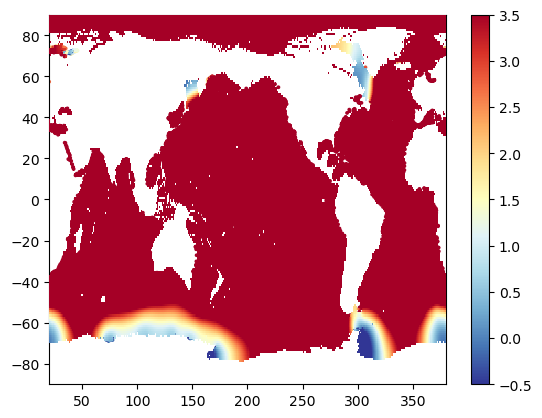

PyObject <matplotlib.colorbar.Colorbar object at 0x7f63bb4defb0>

In [23]:
pcm = plt.pcolormesh(longrid, latgrid, mean(T[depthsel]) .+ Tinterp2[:,:]', 
cmap=plt.cm.RdYlBu_r, vmin=-.5, vmax=3.5, zorder=5)
ax.pcolormesh(longrid, latgrid, mask[:,:,end]', cmap=plt.cm.binary_r, zorder=3)
plt.scatter(obslon[depthsel], obslat[depthsel], s=3, c=T[depthsel], vmin=-0.5, vmax=3.5, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcm)

### Loop on the depth levels

In [24]:
xi, yi, mask3D = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid);  
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);

In [25]:
for dindex in 1:length(depthgrid)
    @info("Working on depth $(depthgrid[dindex])")
    depthsel = findall(obsdepth .== depthgrid[dindex])
    @time Tinterp2D, s2D = DIVAndrun(mask3D[:,:,dindex], (pm, pn), (xi, yi), 
    (obslon[depthsel], obslat[depthsel]), Float64.(T[depthsel] .- mean(T[depthsel])), 
    (lenxy[dindex], lenxy[dindex]), epsilon2, moddim=[1,0]);
end

[ Info: Working on depth 2.5


LoadError: UndefVarError: `lenxy` not defined

2-element Vector{String}:
 "/home/ctroupin/data/ME4OH/data/" ⋯ 55 bytes ⋯ "f.profiles.g10.197901.update.nc"
 "/home/ctroupin/data/ME4OH/data/" ⋯ 55 bytes ⋯ "f.profiles.g10.197902.update.nc"

In [40]:
datadir = "/media/ctroupin/T7 Shield/data/ME4OH/data/en4.1.1/1979-2014/full/update/"
datafilelist = Glob.glob("ofam3*.nc", datadir)


282-element Vector{String}:
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197901.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197902.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197903.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197904.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197905.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197906.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197907.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197908.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197909.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197910.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197911.update.nc"
 "/media/ctroupin/T7 Shield/data/" ⋯ 66 bytes ⋯ "f.profiles.g10.197912